**Notebook to summarize subjects' responses throughout the experiment**

In [106]:
import pandas as pd
import git
import os
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from src.data.utils import *
import scipy.stats as stats
from src.data.eeg_measurement import EegMeasurement
import scipy.stats as stats
from scipy.stats import ttest_rel
#multipletests
from statsmodels.stats.multitest import multipletests
from scipy.stats import wilcoxon
import matplotlib.ticker as mtick
import seaborn as sns
import pingouin as pg

In [46]:
base_dir = base_dir = git.Repo('.', search_parent_directories=True).working_tree_dir
proc_dat_dir = os.path.join(base_dir,"data","processed")
subjects = list(range(102,115))
subjects = subjects + list(range(116,117))
subjects = subjects + list(range(118,126))
subjects = subjects + [127, 128, 130]

subjects = [str(s) for s in subjects]

**Collect Data**

In [47]:
scores_single, scores_competing = [], []

hoer_anstr_pol_single, hoer_anstr_elb_single = [], []
hoer_anstr_pol_comp, hoer_anstr_elb_comp = [], []

story_predictor, story_comp, speaker_comp = [], [], []

for subject in subjects:
    print(subject)
    rand = get_randomisation(int(subject), base_dir)

    info_file = list(filter(lambda file: file.endswith('info.csv'),os.listdir(os.path.join(proc_dat_dir, subject))))[0]
    info_csv = pd.read_csv(os.path.join(proc_dat_dir, subject, info_file))
    scores_single.append(info_csv['score_single_rel'].values[0])
    scores_competing.append(info_csv['score_competing_rel'].values[0])

    story_predictor.append(info_csv['Geschichtenvergleich_Prädiktor'].values[0])
    story_comp.append(info_csv['Geschichtenvergleich'].values[0])
    speaker_comp.append(info_csv['Sprechervergleich'].values[0])

    if rand == 0:
        hoer_anstr_elb_single.append(info_csv['Hoeranstrengung_1'].values[0])
        hoer_anstr_pol_single.append(info_csv['Hoeranstrengung_2'].values[0])

        hoer_anstr_elb_comp.append(info_csv['Hoeranstrengung_3'].values[0])
        hoer_anstr_pol_comp.append(info_csv['Hoeranstrengung_4'].values[0])
    
    elif rand == 1:
        hoer_anstr_elb_single.append(info_csv['Hoeranstrengung_2'].values[0])
        hoer_anstr_pol_single.append(info_csv['Hoeranstrengung_1'].values[0])

        hoer_anstr_elb_comp.append(info_csv['Hoeranstrengung_4'].values[0])
        hoer_anstr_pol_comp.append(info_csv['Hoeranstrengung_3'].values[0])

#cast all lists to numpy arrays
scores_single, scores_competing = np.array(scores_single), np.array(scores_competing)
hoer_anstr_elb_comp, hoer_anstr_pol_comp = np.array(hoer_anstr_elb_comp), np.array(hoer_anstr_pol_comp)
hoer_anstr_elb_simgle, hoer_anstr_elb_single = np.array(hoer_anstr_elb_single), np.array(hoer_anstr_elb_single)


102
103
104
105
106
107
108
109
110
111
112
113
114
116
118
119
120
121
122
123
124
125
127
128
130


In [48]:
info_csv

,Unnamed: 0,Volume,Hoeranstrengung_1,Hoeranstrengung_2,Hoeranstrengung_3,Hoeranstrengung_4,Geschichtenvergleich_Prädiktor,Sprechervergleich,Geschichtenvergleich,score_single_abs,score_single_rel,score_competing_abs,score_competing_rel,score_overall_abs,score_overall_rel
0,0,0.6,5,5,11,11,5.0,1.0,1.0,15,0.9375,12,0.5,27,0.675


In [49]:
scores_single.shape

(25,)

In [50]:
hoer_anstr_comp = np.vstack((hoer_anstr_elb_comp, hoer_anstr_pol_comp)).mean(axis=0)
hoer_anstr_single = np.vstack((hoer_anstr_elb_single, hoer_anstr_pol_single)).mean(axis=0)

hoer_anstr_elb = np.vstack((hoer_anstr_elb_single, hoer_anstr_elb_comp)).mean(axis=0)
hoer_anstr_pol = np.vstack((hoer_anstr_pol_single, hoer_anstr_pol_comp)).mean(axis=0)

**Correct for data loss in subject 101**

In [51]:
def get_score_above_p_val(n, p_level):
    """_summary_

    Args:
        n (int): number of 3AFC questions asked
        p_level (float): significance level

    Returns:
        _type_: _description_
    """
    for successes in range(int(n/3),n):
        p_val = stats.binom_test(x=successes, n=n, p = 1/3)
        if p_val < p_level:
            return successes

In [52]:
def adjust_boxplot(box_plot, line_width, flier_marker=None, colors=None):
    for med in box_plot['medians']:
        med.set_linewidth(line_width)
        med.set_color('black')
    for box in box_plot['boxes']:
        box.set_linewidth(line_width)
        box.set_color('black')
    for whisker in box_plot['whiskers']:
        whisker.set_linewidth(line_width)
        whisker.set_color('black')
    for cap in box_plot['caps']:
        cap.set_linewidth(line_width)
        cap.set_color('black')
    if flier_marker is not None:
        for flier in box_plot['fliers']:
            flier.set_marker(flier_marker)
    if colors is not None:
        for patch, color in zip(box_plot['boxes'], colors):
            patch.set_facecolor(color)
    return box_plot

In [53]:
scores_comp_pol, scores_comp_elb = [], []
scores_single_pol, scores_single_elb = [], []
scores_pol, scores_elb = [], []
scores_comp_pol_trials, scores_comp_elb_trials = [], []

for subject in subjects:
    print(subject)
    trial_file = list(filter(lambda file: file.endswith('trials.csv'),os.listdir(os.path.join(proc_dat_dir, subject))))[0]
    trial_csv = pd.read_csv(os.path.join(proc_dat_dir, subject, trial_file))

    polarnacht_competing = trial_csv.where(trial_csv['attended_story'] == 'Polarnacht', inplace=False)[8:]
    polarnacht_competing.dropna(inplace=True)
    pol_comp_score = (polarnacht_competing['answer_1_score'].sum() + polarnacht_competing['answer_2_score'].sum())

    polarnacht_single = trial_csv.where(trial_csv['attended_story'] == 'Polarnacht', inplace=False)[:8]
    polarnacht_single.dropna(inplace=True)
    pol_single_score = (polarnacht_single['answer_1_score'].sum() + polarnacht_single['answer_2_score'].sum())

    elben_competing = trial_csv.where(trial_csv['attended_story'] == 'Elbenwald', inplace=False)[8:]
    elben_competing.dropna(inplace=True)
    elb_com_score = (elben_competing['answer_1_score'].sum() + elben_competing['answer_2_score'].sum())

    elben_single = trial_csv.where(trial_csv['attended_story'] == 'Elbenwald', inplace=False)[:8]
    elben_single.dropna(inplace=True)
    elb_single_score = (elben_single['answer_1_score'].sum() + elben_single['answer_2_score'].sum())

    scores_comp_pol.append(pol_comp_score / 12)
    scores_comp_elb.append(elb_com_score / 12)
    scores_single_pol.append(pol_single_score / 8)
    scores_single_elb.append(elb_single_score / 8)

    scores_pol.append((pol_single_score + pol_comp_score) / 20)
    scores_elb.append((elb_single_score + elb_com_score) / 20)

    scores_comp_pol_trials.append(polarnacht_competing['answer_1_score'] + polarnacht_competing['answer_2_score'])
    scores_comp_elb_trials.append(elben_competing['answer_1_score'] + elben_competing['answer_2_score'])
#cast alles lists to numpy arrays
scores_comp_pol, scores_comp_elb = np.array(scores_comp_pol), np.array(scores_comp_elb)
scores_single_pol, scores_single_elb = np.array(scores_single_pol), np.array(scores_single_elb)
scores_pol, scores_elb = np.array(scores_pol), np.array(scores_elb)

102
103
104
105
106
107
108
109
110
111
112
113
114
116
118
119
120
121
122
123
124
125
127
128
130


scores_single_elb.shape

In [107]:
pg.wilcoxon(scores_single_pol, scores_single_elb)

/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,W-val,alternative,p-val,RBC,CLES
Wilcoxon,10.5,two-sided,0.587746,0.25,0.54


In [108]:
pg.wilcoxon(scores_comp_elb, scores_comp_pol)

/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,W-val,alternative,p-val,RBC,CLES
Wilcoxon,25.0,two-sided,0.004845,-0.736842,0.3328


In [103]:
w_single_st = wilcoxon(scores_single_elb, scores_single_pol, correction=True)
w_comp_story = wilcoxon(scores_comp_elb, scores_comp_pol, correction=True)
print(f'Single speaker: {w_single_st}')
print(f'Competing stories: {w_comp_story}')

corrected = multipletests([w_single_st.pvalue, w_comp_story.pvalue], alpha=0.05, method='fdr_bh')
p_single_corrected, p_comp_corrected = corrected[1]

print(f"Single Story: {w_single_st.pvalue} Corrected: {p_single_corrected}")
print(f"Competing Stories: {w_comp_story.pvalue} Corrected: {p_comp_corrected}")

Single speaker: WilcoxonResult(statistic=10.5, pvalue=0.587746352368953)
Competing stories: WilcoxonResult(statistic=25.0, pvalue=0.004845195084940606)
Single Story: 0.587746352368953 Corrected: 0.587746352368953
Competing Stories: 0.004845195084940606 Corrected: 0.009690390169881212


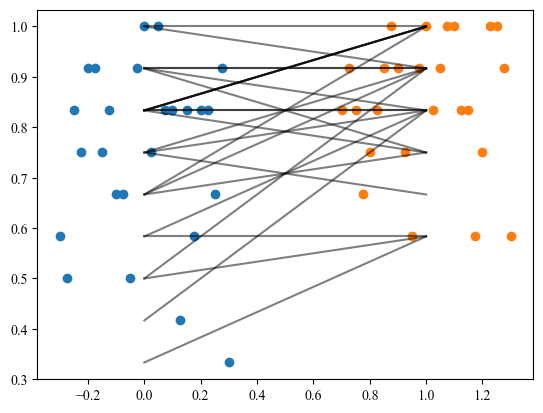

In [100]:
plt.scatter(np.linspace(0-0.3, 0+ 0.3, scores_comp_elb.shape[0]), scores_comp_elb)
plt.scatter(np.linspace(1-0.3, 1+ 0.3, scores_comp_elb.shape[0]), scores_comp_pol)
#connect the dots
for i in range(scores_comp_elb.shape[0]):
    plt.plot([0, 1], [scores_comp_elb[i], scores_comp_pol[i]], color='black', alpha=0.5)

In [109]:
w_single_st_hoer = wilcoxon(hoer_anstr_elb_single, hoer_anstr_pol_single, correction=True)
w_comp_st_hoer = wilcoxon(hoer_anstr_elb_comp, hoer_anstr_pol_comp, correction=True)
print(f'Single Speaker: {w_single_st_hoer}')
print(f'Competing speaker: {w_comp_st_hoer}')

corrected_hoer = corrected = multipletests([w_single_st_hoer.pvalue, w_comp_st_hoer.pvalue], alpha=0.05, method='fdr_bh')
p_single_corr_hoer, p_comp_corr_hoer = corrected_hoer[1]
print(f'Single p-value corrected:{p_single_corr_hoer}')
print(f'Competing p-value corrected{p_comp_corr_hoer}')

Single Speaker: WilcoxonResult(statistic=11.0, pvalue=0.0016034192112405045)
Competing speaker: WilcoxonResult(statistic=4.0, pvalue=0.00344629894608082)
Single p-value corrected:0.003206838422481009
Competing p-value corrected0.00344629894608082


/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [56]:
corrected = multipletests([w_single_st.pvalue, w_comp_story.pvalue], alpha=0.05, method='fdr_bh')
p_single_corrected, p_comp_corrected = corrected[1]

print(f"Single Story: {w_single_st.pvalue} Corrected: {p_single_corrected}")

Single Story: 0.00022271331011314643 Corrected: 0.00044542662022629286


In [57]:
#create dataframes for the scores
n_single, n_comp = len(scores_single), len(scores_comp_pol)
scores_dict = {'values': np.concatenate((scores_single_elb, scores_single_pol, scores_comp_elb, scores_comp_pol)), 
               'speaker_condition': ['single speaker']*n_single + ['single speaker']*n_single + ['competing speaker']*n_comp + ['competing speaker']*n_comp,
               'story_condition': ['s1']*n_single + ['s2']*n_single + ['s1']*n_comp + ['s2']*n_comp}
scores_df = pd.DataFrame(scores_dict)

In [58]:
#create dataframe for hoeranst
n_single, n_comp = len(hoer_anstr_elb_single), len(hoer_anstr_elb_comp)
list_eff_dict = {'values': np.concatenate((hoer_anstr_elb_single, hoer_anstr_pol_single, hoer_anstr_elb_comp, hoer_anstr_pol_comp)),
                 'speaker_condition': ['single_speaker']*(2*n_single) + ['competing_speaker']*(2*n_comp),
                 'story_condition': ['s1']*n_single + ['s2']*n_single + ['s1']*n_comp + ['s2']*n_comp}
list_eff_df = pd.DataFrame(list_eff_dict)

In [59]:
scores_df

,values,speaker_condition,story_condition
0,1.000000,single speaker,s1
1,1.000000,single speaker,s1
2,1.000000,single speaker,s1
3,1.000000,single speaker,s1
4,1.000000,single speaker,s1
...,...,...,...
95,0.750000,competing speaker,s2
96,1.000000,competing speaker,s2
97,1.000000,competing speaker,s2
98,0.916667,competing speaker,s2


In [60]:
scores_comp_pol_trials = np.array(scores_comp_pol_trials) / 2
scores_comp_elb_trials = np.array(scores_comp_elb_trials) / 2

overall_trial_scores = np.concatenate((scores_comp_elb_trials[:,:2], scores_comp_pol_trials[:,:2],
                                      scores_comp_elb_trials[:,2:4], scores_comp_pol_trials[:,2:4],
                                        scores_comp_elb_trials[:,4:], scores_comp_pol_trials[:,4:]), axis=1)


**Comprehensive Boxplot**

In [61]:
c_cnn = '#1f77b4'
c_ridge = '#ff7f0e'

box_plot_widts = 0.2
box_plot_line_width = 0.8
axis_linewidth = 1.0
conf_linewidth = 0.8
box_plot_colors = ['steelblue', 'goldenrod']
box_plot_colors_2 = ['slategrey', 'darkseagreen']
titles = ['(a)\n', '(b)', '(c)\n', '(d)']
x_pos_title = 0.2
y_pos_titles = [1.05, 16, 1.05, 16]
box_plot_flier_marker = 'x'
flierprops = dict(marker='x', markerfacecolor='k', markersize=3, markeredgewidth=0.6)
positions = np.array([[i-(box_plot_widts/2 + 0.02), i+(box_plot_widts/2 + 0.02)] for i in range(1,2)]).flatten()

scatter_delta = 0.06
marker = 'o'
marker_size = 10
tick_fontsize = 9
label_fontsize = 8.5
labels = ['Comprehension\nScore', 'Listening\nEffort']
legend_fontsize = 9
plt.rcParams["font.family"] = "Times New Roman"

In [62]:
ttest_rel(scores_pol, scores_elb)

TtestResult(statistic=3.0887493700213775, pvalue=0.005021189478810479, df=24)

/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


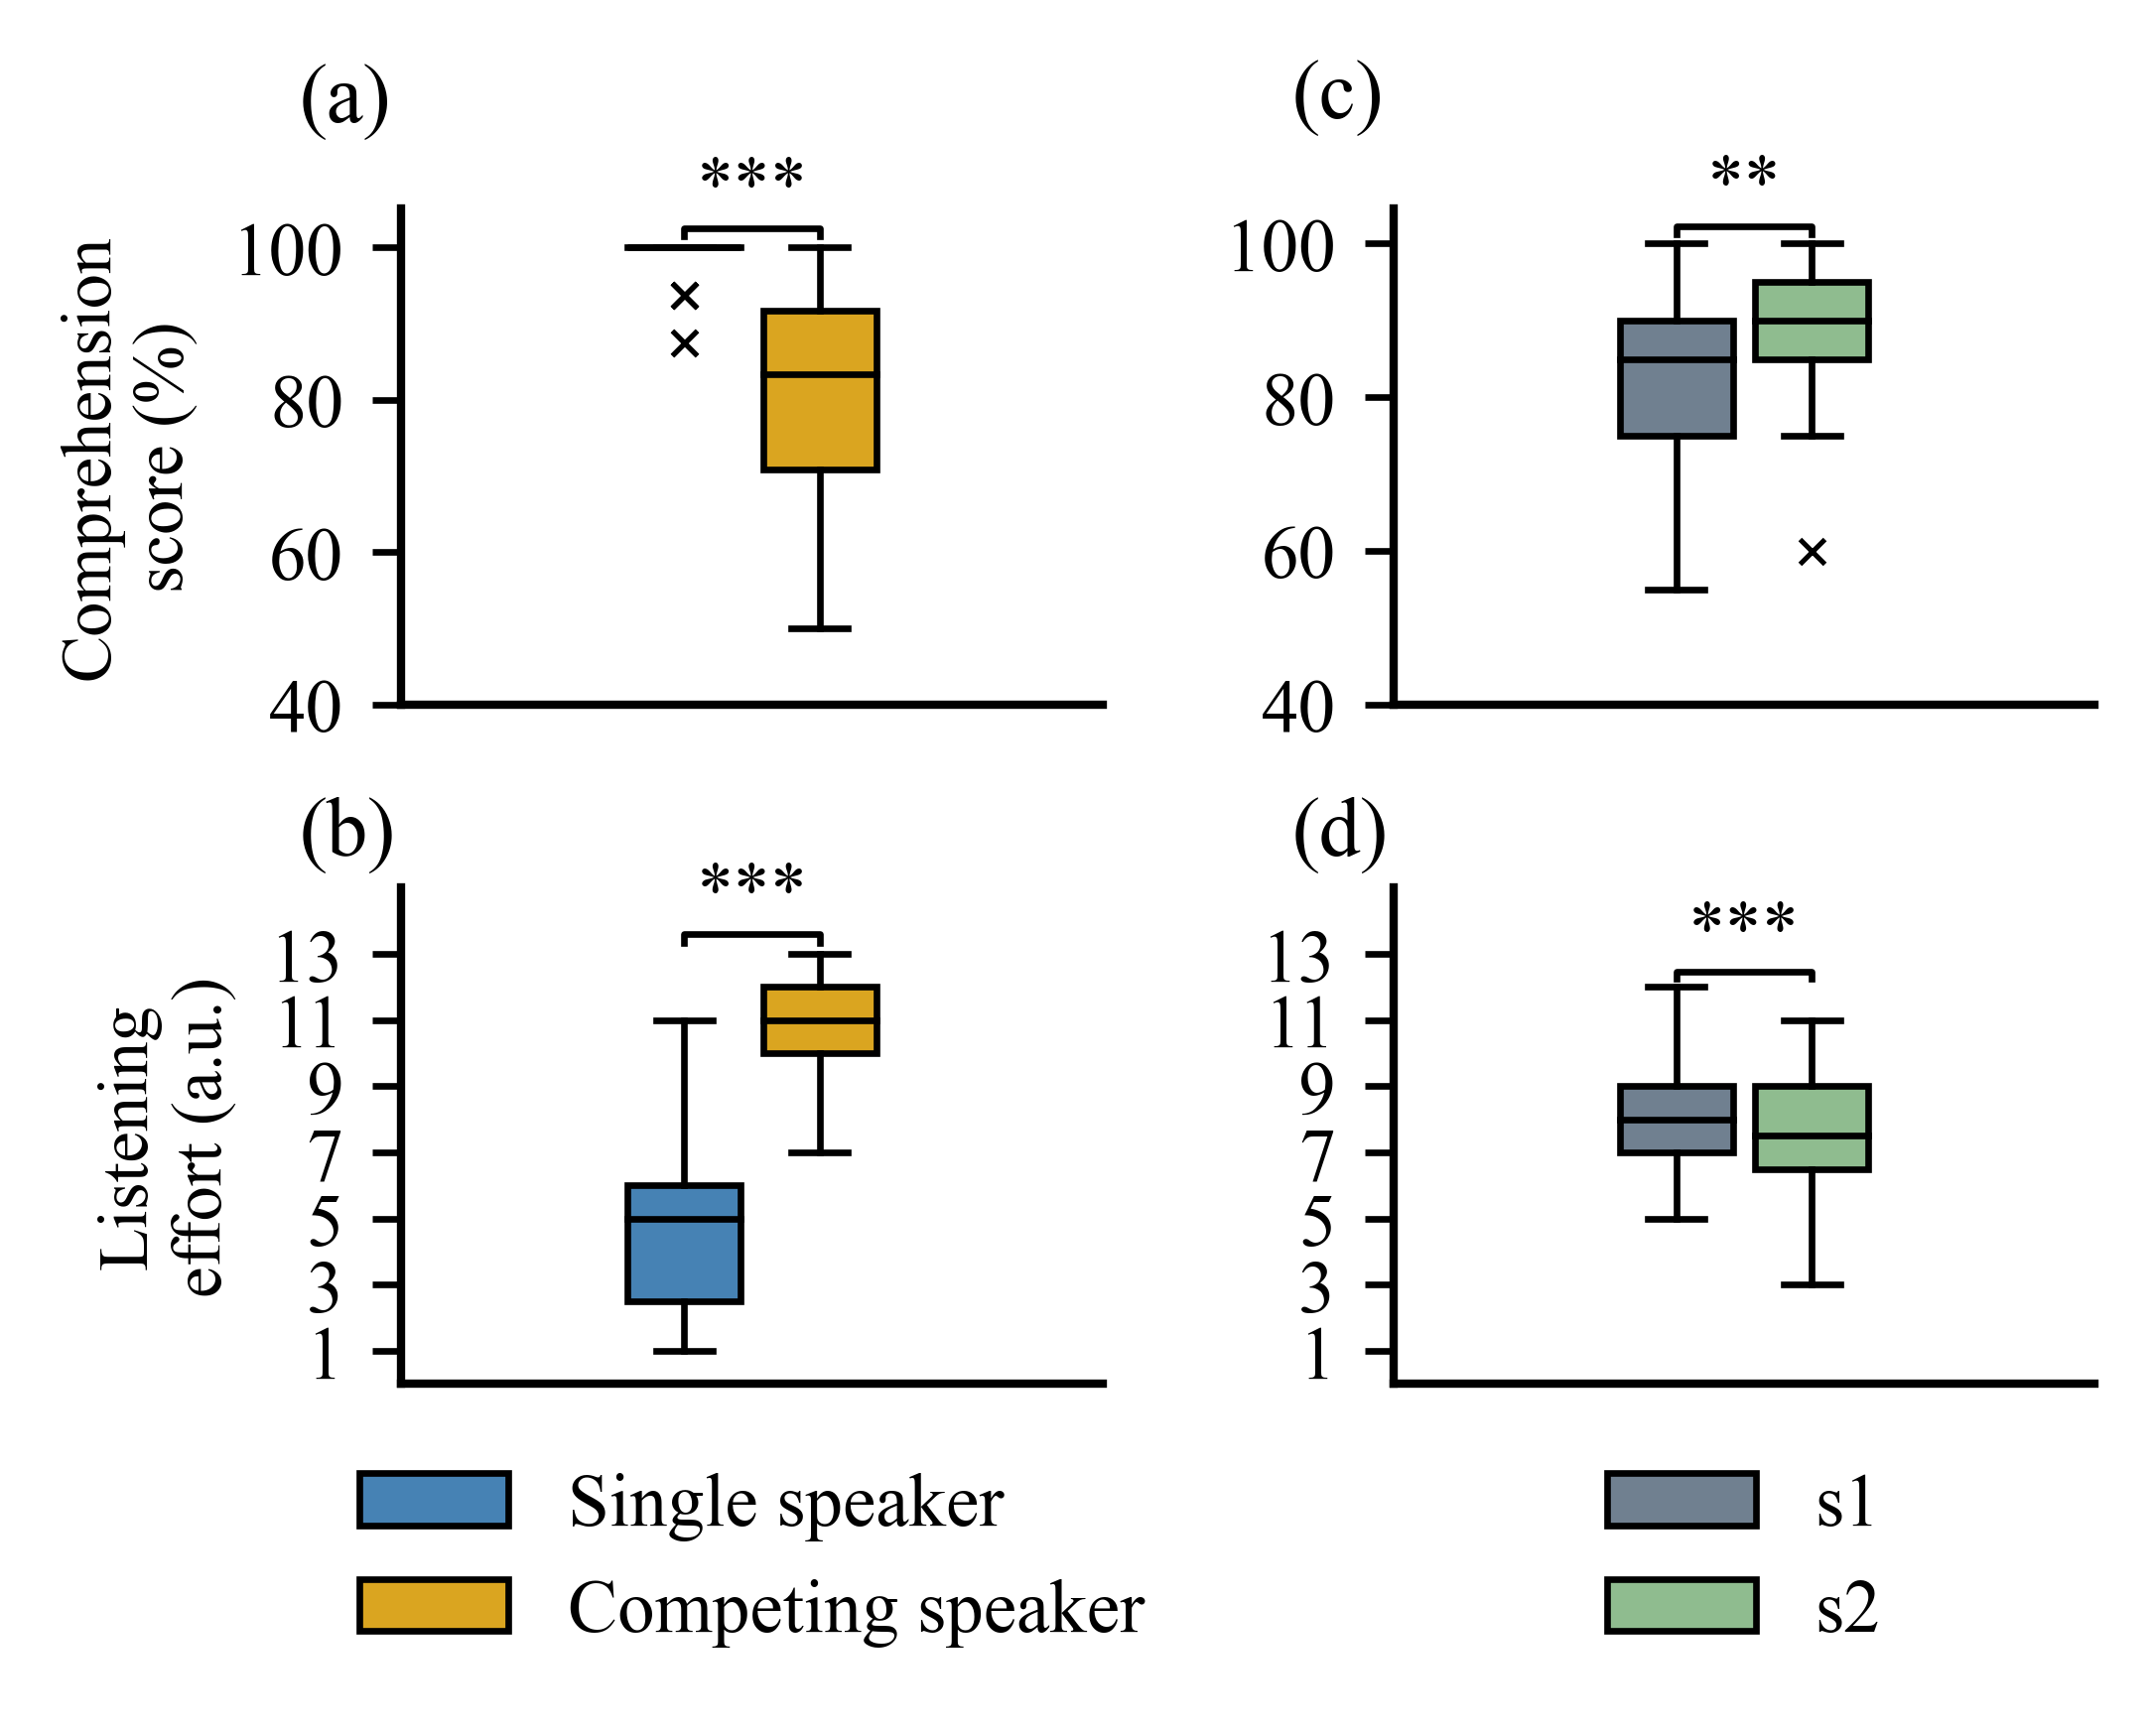

In [63]:
box_plot_data_0 = np.vstack((scores_single.flatten(), scores_competing.flatten())).T
box_plot_data_1 = np.vstack((hoer_anstr_single.flatten(), hoer_anstr_comp.flatten())).T
box_plot_data_2 = np.vstack((scores_elb.flatten(), scores_pol.flatten())).T
box_plot_data_3 = np.vstack((hoer_anstr_elb, hoer_anstr_pol)).T

significances = [ttest_rel(scores_single, scores_competing), ttest_rel(hoer_anstr_single, hoer_anstr_comp),
                ttest_rel(scores_pol, scores_elb), ttest_rel(hoer_anstr_pol, hoer_anstr_elb)]
significances_wilk = [wilcoxon(scores_single, scores_competing), wilcoxon(hoer_anstr_single, hoer_anstr_comp),
                wilcoxon(scores_pol, scores_elb), wilcoxon(hoer_anstr_pol, hoer_anstr_elb)]
p_vals = [s[1] for s in significances_wilk]

fig = plt.figure(figsize=(3.5,2.8), layout = 'constrained', dpi=600)
spec = fig.add_gridspec(3,2, width_ratios = [1, 1], height_ratios = [1,1,0.2], wspace=0.0, hspace=0.05)
ax,ax3 = fig.add_subplot(spec[0,0]), fig.add_subplot(spec[0,1])
ax1, ax4 = fig.add_subplot(spec[1,0]), fig.add_subplot(spec[1,1])
ax2, ax5 = fig.add_subplot(spec[2,0]), fig.add_subplot(spec[2,1])

#all dataplot
list_boxplots = []
for data, axis, colors, title, y_pos in zip([box_plot_data_0, box_plot_data_1, box_plot_data_2, box_plot_data_3], [ax,ax1,ax3,ax4], [box_plot_colors, box_plot_colors, box_plot_colors_2, box_plot_colors_2], titles, y_pos_titles):
    box_plot = axis.boxplot(data, widths=box_plot_widts, positions=positions, patch_artist=True, showfliers=True, flierprops=flierprops)
    box_plot = adjust_boxplot(box_plot, box_plot_line_width, flier_marker=box_plot_flier_marker, colors=colors)
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.set_xticks(list(range(1,2)))
    axis.tick_params(axis='y', labelsize=tick_fontsize)
    axis.tick_params(axis='x', bottom = False)
    list_boxplots.append(box_plot)
    #axis.set_title(title, fontsize = label_fontsize)
    axis.text(x_pos_title, y_pos, title)
    axis.spines['bottom'].set_linewidth(axis_linewidth)
    axis.spines['left'].set_linewidth(axis_linewidth)

#legend ax
for axis in [ax2, ax5]:
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.spines['left'].set_visible(False)
    axis.spines['bottom'].set_visible(False)
    axis.set_xticks([])
    axis.set_yticks([])

ax.set_xticklabels([''], fontsize = label_fontsize)
ax1.set_xticklabels([''], fontsize = label_fontsize)

ax3.set_xticklabels([''], fontsize = label_fontsize)
ax4.set_xticklabels([''], fontsize = label_fontsize)

ax2.legend([list_boxplots[0]["boxes"][0], list_boxplots[0]["boxes"][1]], ['Single speaker', 'Competing speaker'], loc='center', fontsize=legend_fontsize, ncols = 1, frameon=False)
ax5.legend([list_boxplots[2]["boxes"][0], list_boxplots[2]["boxes"][1]], ['s1', 's2'], loc='center', fontsize=legend_fontsize, ncols = 1, frameon=False)



#significance bars
for n, p, axes in zip(range(0,len(p_vals)), p_vals, [ax, ax1, ax3, ax4]):
    bottom, top = axes.get_ylim()
    y_range = top - bottom
    x_0 = positions[0]
    x_1 = positions[1]
    level = 0
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    axes.plot([x_0, x_0, x_1, x_1], [bar_tips, bar_height, bar_height, bar_tips], lw=conf_linewidth, c='k')
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = 'n.s.'

    text_height = bar_height + (y_range * 0.01)
    axes.text((x_0 + x_1)/2, text_height, sig_symbol, ha='center', va='bottom', color='k', fontsize=tick_fontsize)

#Question Scres
for axis in [ax,ax3]:
    
    axis.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0, symbol=None))
    axis.set_yticks([0.4,0.6,0.8,1.0])
ax.set_ylabel('Comprehension\nscore (%)', fontsize = label_fontsize)

# Listening Effort 
for axis in [ax1,ax4]:
    axis.set_yticks(list(range(1,14,2)))
    axis.set_ylim(0,15)
ax1.set_ylabel('Listening\neffort (a.u.)', fontsize = label_fontsize)


fig_path = os.path.join(base_dir, 'reports', 'figures', 'responses', 'overview_ci')
extensions = ['.png', '.svg', '.pdf']
for ext in extensions:
    fig.savefig(fig_path + ext, bbox_inches='tight', dpi=600)


/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_42449/2460095959.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''], fontsize = label_fontsize)
/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_42449/2460095959.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels([''], fontsize = label_fontsize)
/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_42449/2460095959.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels([''], fontsize = label_fontsize)
/var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_4244

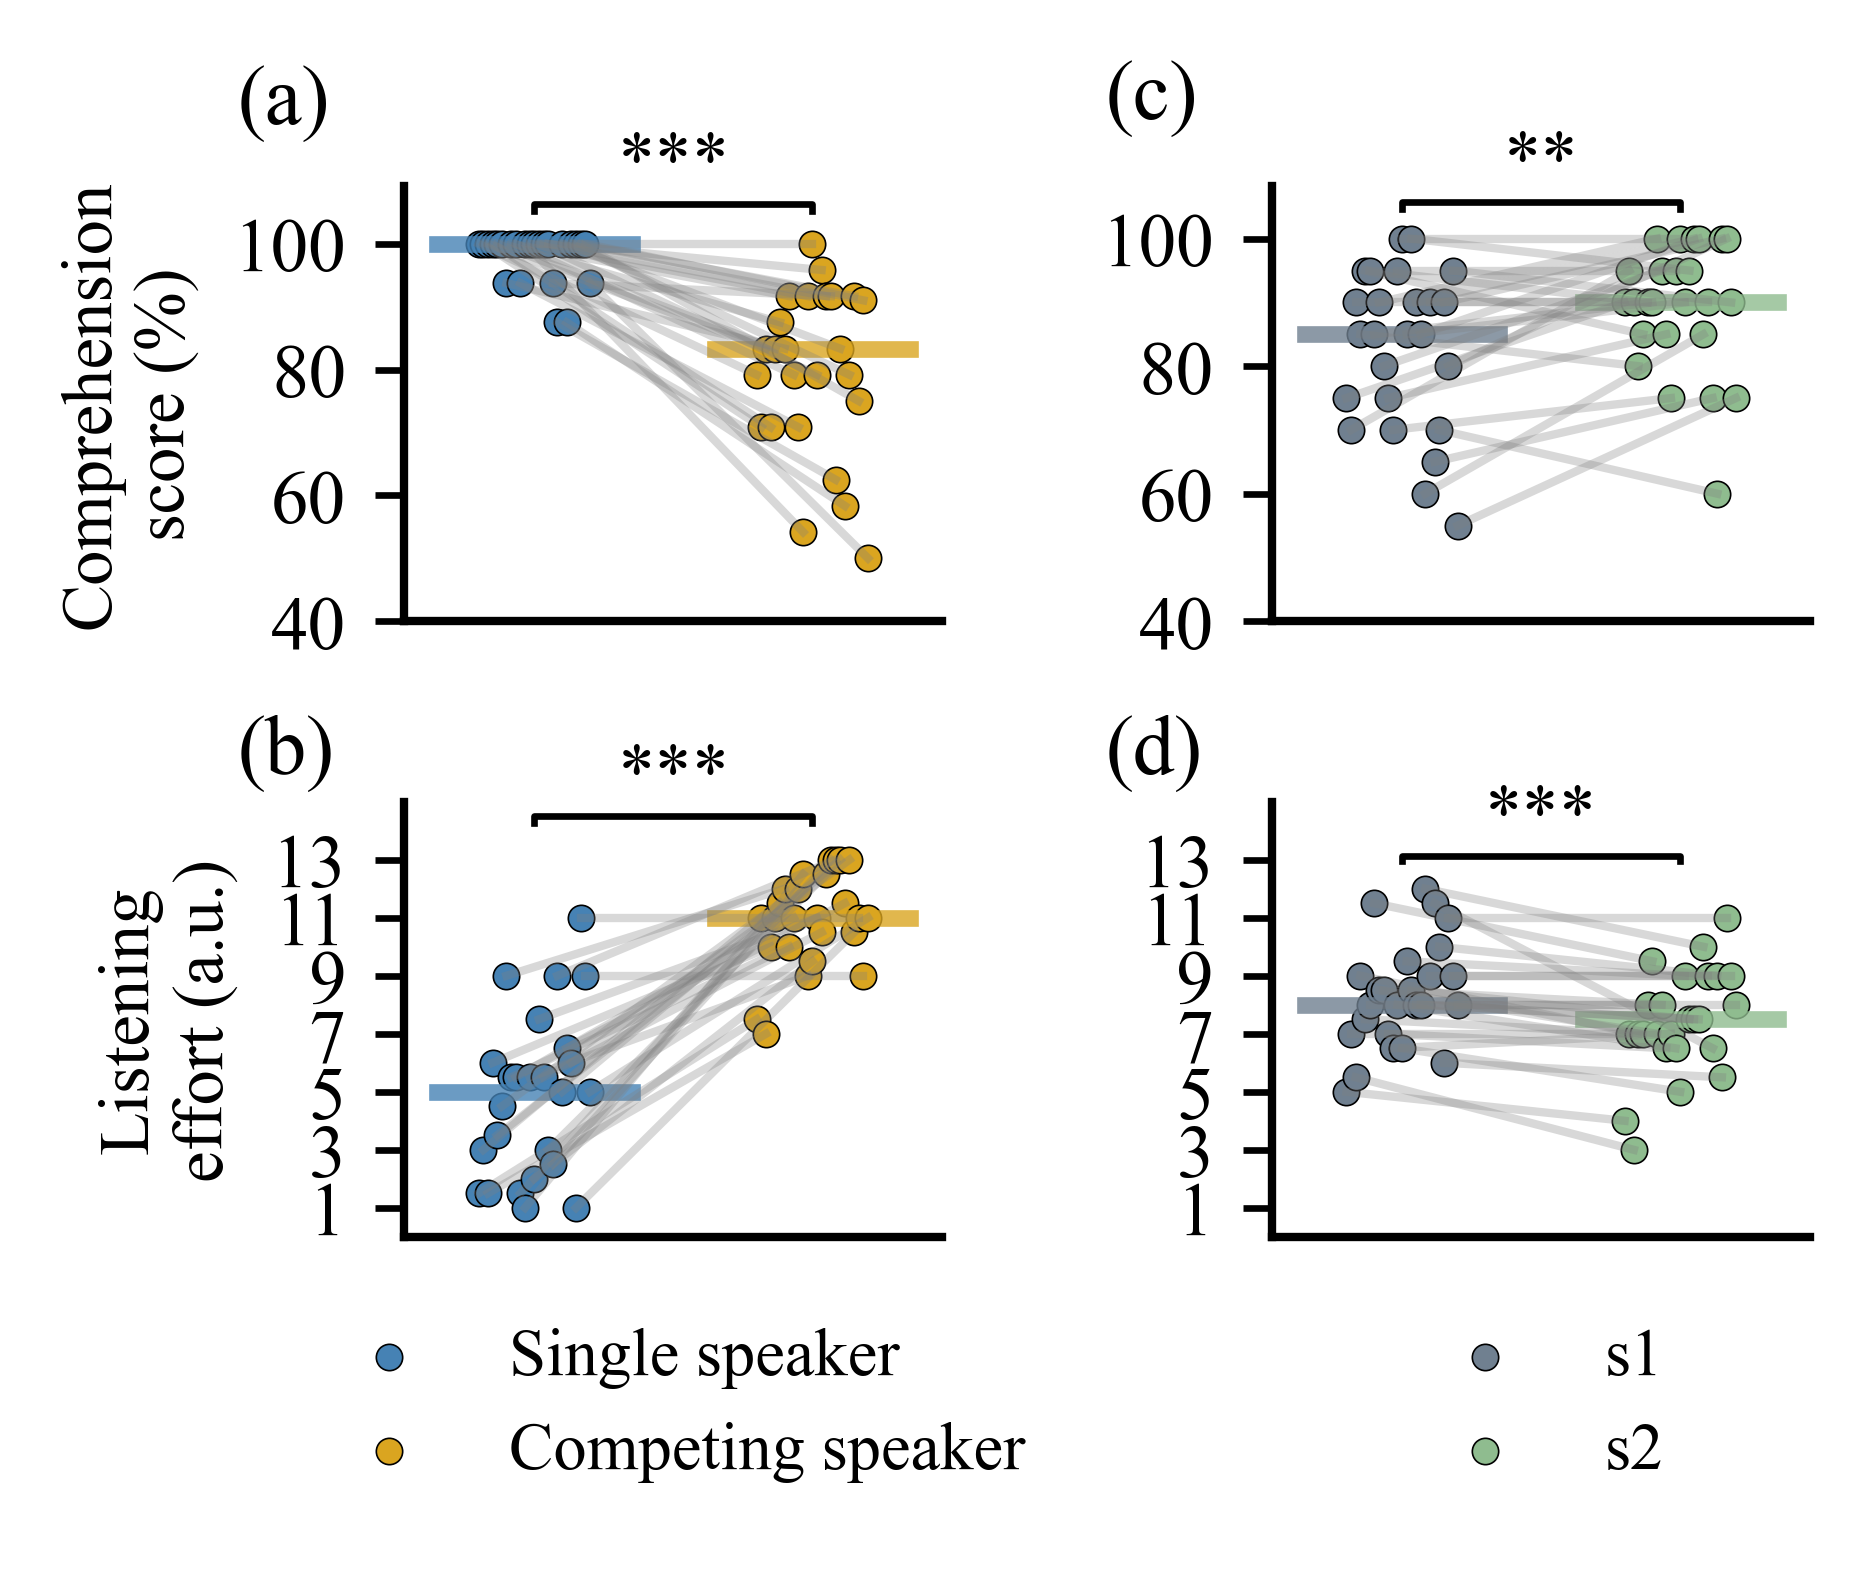

In [88]:
x_0, x_1 = 1,1.75
s = 10

spacing = 0.15

box_plot_data_0 = np.vstack((scores_single.flatten(), scores_competing.flatten())).T
box_plot_data_1 = np.vstack((hoer_anstr_single.flatten(), hoer_anstr_comp.flatten())).T
box_plot_data_2 = np.vstack((scores_elb.flatten(), scores_pol.flatten())).T
box_plot_data_3 = np.vstack((hoer_anstr_elb, hoer_anstr_pol)).T

# significances = [ttest_rel(scores_single, scores_competing), ttest_rel(hoer_anstr_single, hoer_anstr_comp),
#                 ttest_rel(scores_pol, scores_elb), ttest_rel(hoer_anstr_pol, hoer_anstr_elb)]

# significances_wilk = [wilcoxon(scores_single, scores_competing), wilcoxon(hoer_anstr_single, hoer_anstr_comp),
#                 wilcoxon(scores_pol, scores_elb), wilcoxon(hoer_anstr_pol, hoer_anstr_elb)]

sign_scores, sign_hoer = [wilcoxon(scores_single, scores_competing).pvalue, wilcoxon(scores_pol, scores_elb).pvalue], [wilcoxon(hoer_anstr_single, hoer_anstr_comp).pvalue, wilcoxon(hoer_anstr_pol, hoer_anstr_elb).pvalue]
sign_scores_corrected = multipletests(sign_scores, method='fdr_bh')
sign_hoer_corrected = multipletests(sign_hoer, method='fdr_bh')
significances_wilk = [sign_scores_corrected[1][0], sign_hoer_corrected[1][0], sign_scores_corrected[1][1], sign_hoer_corrected[1][1]]

p_vals = [s for s in significances_wilk]

fig = plt.figure(figsize=(3,2.5), layout = 'constrained', dpi=600)
spec = fig.add_gridspec(3,2, width_ratios = [1, 1], height_ratios = [1,1,0.2], wspace=0.0, hspace=0.05)
ax,ax3 = fig.add_subplot(spec[0,0]), fig.add_subplot(spec[0,1])
ax1, ax4 = fig.add_subplot(spec[1,0]), fig.add_subplot(spec[1,1])
ax2, ax5 = fig.add_subplot(spec[2,0]), fig.add_subplot(spec[2,1])

#all dataplot
list_boxplots = []
for data, axis, colors, title, y_pos in zip([box_plot_data_0, box_plot_data_1, box_plot_data_2, box_plot_data_3], [ax,ax1,ax3,ax4], [box_plot_colors, box_plot_colors, box_plot_colors_2, box_plot_colors_2], titles, y_pos_titles):
    scatter_0 = axis.scatter(np.linspace(x_0-spacing, x_0 + spacing, data.shape[0]), data[:,0],c=colors[0], s=s, edgecolors='k', linewidths=0.2)
    median_0 = axis.plot([x_0-(1.75*spacing), x_0 + (1.75*spacing)], [np.median(data[:,0]), np.median(data[:,0])], c = colors[0], linewidth=2, alpha=0.8)
    
    scatter_1 = axis.scatter(np.linspace(x_1-spacing, x_1 + spacing, data.shape[0]), data[:,1], c=colors[1], s=s, edgecolors='k', linewidths=0.2)
    median_1 = axis.plot([x_1-(1.75*spacing), x_1 + (1.75*spacing)], [np.median(data[:,1]), np.median(data[:,1])], c = colors[1], linewidth=2, alpha=0.8)
    if axis == ax:
        ax2.legend([scatter_0, scatter_1], ['Single speaker', 'Competing speaker'], loc='center', fontsize=8, ncols = 1, frameon=False)
    elif axis == ax4:
        ax5.legend([scatter_0, scatter_1], ['s1', 's2'], loc='center', fontsize=8, ncols = 1, frameon=False)
    
    x_0_list = list(np.linspace(x_0-spacing, x_0 + spacing, data.shape[0]))
    x_1_list = list(np.linspace(x_1-spacing, x_1 + spacing, data.shape[0]))
    for i in range(0,data.shape[0]):
        axis.plot([x_0_list[i], x_1_list[i]],data[i,:], c='grey', linewidth=1, alpha=0.3)
    lines = axis.plot
    #line_object = lines.Line2D
    #box_plot = axis.boxplot(data, widths=box_plot_widts, positions=positions, patch_artist=True, showfliers=True, flierprops=flierprops)
    #box_plot = adjust_boxplot(box_plot, box_plot_line_width, flier_marker=box_plot_flier_marker, colors=colors)
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    #axis.set_xticks(list(range(1,2)))
    axis.tick_params(axis='y', labelsize=tick_fontsize)
    axis.tick_params(axis='x', bottom = False)
    list_boxplots.append(box_plot)
    #axis.set_title(title, fontsize = label_fontsize)
    axis.text(x_pos_title, y_pos, title)
    axis.spines['bottom'].set_linewidth(axis_linewidth)
    axis.spines['left'].set_linewidth(axis_linewidth)

#legend ax
for axis in [ax2, ax5]:
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.spines['left'].set_visible(False)
    axis.spines['bottom'].set_visible(False)
    axis.set_xticks([])
    axis.set_yticks([])

ax.set_xticklabels([''], fontsize = label_fontsize)
ax1.set_xticklabels([''], fontsize = label_fontsize)

ax3.set_xticklabels([''], fontsize = label_fontsize)
ax4.set_xticklabels([''], fontsize = label_fontsize)

# ax2.legend([scatter_0, scatter_1], ['Single speaker', 'Competing speaker'], loc='center', fontsize=legend_fontsize, ncols = 1, frameon=False)
# ax5.legend([scatter_0, scatter_1], ['Single speaker', 'Competing speaker'], loc='center', fontsize=legend_fontsize, ncols = 1, frameon=False)



#significance bars
for n, p, axes in zip(range(0,len(p_vals)), p_vals, [ax, ax1, ax3, ax4]):
    bottom, top = axes.get_ylim()
    y_range = top - bottom
    # x_0 = 1
    # x_1 = 2
    level = 1
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    axes.plot([x_0, x_0, x_1, x_1], [bar_tips, bar_height, bar_height, bar_tips], lw=conf_linewidth, c='k')
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = 'n.s.'

    text_height = bar_height + (y_range * 0.01)
    axes.text((x_0 + x_1)/2, text_height, sig_symbol, ha='center', va='bottom', color='k', fontsize=tick_fontsize)

#Question Scres
for axis in [ax,ax3]:
    axis.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0, symbol=None))
    axis.set_yticks([0.4,0.6,0.8,1.0])
for axis in [ax,ax1,ax3,ax4]:
    axis.set_xlim(x_0-0.35,x_1+0.35)
ax.set_ylabel('Comprehension\nscore (%)', fontsize = label_fontsize)

# Listening Effort 
for axis in [ax1,ax4]:
    axis.set_yticks(list(range(1,14,2)))
    axis.set_ylim(0,15)
ax1.set_ylabel('Listening\neffort (a.u.)', fontsize = label_fontsize)


fig_path = os.path.join(base_dir, 'reports', 'figures', 'responses', 'overview_scatter')
extensions = ['.png', '.svg', '.pdf']
for ext in extensions:
    fig.savefig(fig_path + ext, bbox_inches='tight', dpi=600)

In [ ]:
significances_wilk = [wilcoxon(scores_single, scores_competing), wilcoxon(hoer_anstr_single, hoer_anstr_comp),
                wilcoxon(scores_pol, scores_elb), wilcoxon(hoer_anstr_pol, hoer_anstr_elb)]
significances_wilk

/Users/constantin/opt/anaconda3/envs/model_dev_aad_semeco/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


[WilcoxonResult(statistic=0.0, pvalue=1.77015518888593e-05),
 WilcoxonResult(statistic=0.0, pvalue=2.6727785855344405e-05),
 WilcoxonResult(statistic=33.5, pvalue=0.004157361485511537),
 WilcoxonResult(statistic=4.5, pvalue=0.00023522778056266227)]

In [89]:
np.min(scores_competing)

0.5

In [ ]:
shapiro_scores_single = stats.shapiro(scores_single)
print(f'shapiro_scores_single: {shapiro_scores_single}')
shapiro_scores_competing = stats.shapiro(scores_competing)
print(f'shapiro_scores_competing: {shapiro_scores_competing}')
shapiro_listening_single = stats.shapiro(hoer_anstr_elb_single)
print(f'Shapiro Höranstrengung single {shapiro_listening_single}')
shapiro_listeing_comp = stats.shapiro(hoer_anstr_comp)
print(f'Shapiro Höranstrenung comp{shapiro_listeing_comp}')

shapiro_scores_single: ShapiroResult(statistic=0.5660293102264404, pvalue=1.792942612155457e-07)
shapiro_scores_competing: ShapiroResult(statistic=0.9314972758293152, pvalue=0.09411399066448212)
Shapiro Höranstrengung single ShapiroResult(statistic=0.9387575387954712, pvalue=0.13855896890163422)
Shapiro Höranstrenung compShapiroResult(statistic=0.9285044074058533, pvalue=0.08027037233114243)


In [ ]:
shapiro_scores_s1 = stats.shapiro(scores_pol)
print(f'Shapiro scores Pol {shapiro_scores_s1}')
shapiro_scores_s2 = stats.shapiro(scores_elb)
print(f'Shapiro scores Elb: {shapiro_scores_s2}')

shapiro_list_pol = stats.shapiro(hoer_anstr_pol)
print(f'Shapiro list eff pol{shapiro_list_pol}')
shapiro_list_elb = stats.shapiro(hoer_anstr_elb)
print(f'Shapiro list elb:{shapiro_list_elb}')

Shapiro scores Pol ShapiroResult(statistic=0.8768150210380554, pvalue=0.005944392643868923)
Shapiro scores Elb: ShapiroResult(statistic=0.9360372424125671, pvalue=0.11986540257930756)
Shapiro list eff polShapiroResult(statistic=0.9667438864707947, pvalue=0.5641114115715027)
Shapiro list elb:ShapiroResult(statistic=0.9644527435302734, pvalue=0.5100547075271606)


In [ ]:
scores_single_elb

array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       0.875, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.875, 0.875,
       1.   , 0.75 , 0.5  , 1.   , 1.   , 1.   , 0.875])

In [ ]:
from pingouin import ancova, read_dataset
df = read_dataset('ancova')

In [74]:
x_0_list = list(np.linspace(x_0-0.06, x_0 + 0.06, data.shape[0]))

In [75]:
x_0_list

[0.94,
 0.945,
 0.95,
 0.955,
 0.96,
 0.965,
 0.97,
 0.975,
 0.98,
 0.985,
 0.99,
 0.995,
 1.0,
 1.005,
 1.01,
 1.0150000000000001,
 1.02,
 1.025,
 1.03,
 1.0350000000000001,
 1.04,
 1.045,
 1.05,
 1.0550000000000002,
 1.06]